# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:

from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
! dir /content/drive/MyDrive/data_cp

test_32x32.mat	train_32x32.mat


In [3]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np


For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [4]:
# Run this cell to load the dataset

train = loadmat('/content/drive/MyDrive/data_cp/train_32x32.mat')
test = loadmat('/content/drive/MyDrive/data_cp/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [5]:
print(train.keys())
print(test.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [6]:
xTrain = train["X"]
yTrain = train["y"]
xTest = test["X"]
yTest = test["y"]
print(type(xTrain))
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

yTrain[yTrain == 10] = 0
yTest[yTest == 10] = 0

<class 'numpy.ndarray'>
(32, 32, 3, 73257)
(73257, 1)
(32, 32, 3, 26032)
(26032, 1)


In [7]:
def dataSet2GrayScale(xTrain,xTest):
    # extract number of images from both sets
    trainLen = xTrain.shape[3]
    testLen = xTest.shape[3]
    # get average reshape, normalize
    xTrainNew = np.mean(xTrain,2).reshape(32,32,1,trainLen)
    xTestNew = np.mean(xTest,2).reshape(32,32,1,testLen)
    # reshape and normalize
    xTrainNew = np.moveaxis(xTrainNew,-1,0) /255.0
    xTestNew = np.moveaxis(xTestNew,-1,0) /255.0
    return xTrainNew , xTestNew


In [8]:
xTrainGray, xTestGray = dataSet2GrayScale(xTrain,xTest)
print(xTrainGray.shape)
print(xTestGray.shape)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


In [9]:
def plotImages(dataSet,labels,rows,cols):
    fig,axes = plt.subplots(rows,cols)
    for index,axis in enumerate(axes.flat):
        img = np.random.choice(dataSet.shape[0], 1)[-1]
        if dataSet[img].shape[2] == 1:
            axis.imshow(dataSet[img,:,:,0], cmap='gray')
        else:
            #print(dataSet[:,:,:,img].shape)
            axis.imshow(dataSet[:,:,:,img])
        axis.axis('off')
        axis.set_title(labels[img])        
    

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


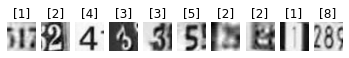

In [10]:
plotImages(xTrainGray,yTrain,1,10)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


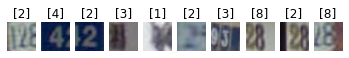

In [11]:
plotImages(xTrain,yTrain,1,10)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.layers import Dense, Flatten,Conv2D, MaxPool2D,Dropout
from sklearn.model_selection import train_test_split



In [13]:
labels = list(np.unique(yTrain))
print(labels,len(labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 10


In [14]:
yTrain = tf.keras.utils.to_categorical(yTrain)
yTest = tf.keras.utils.to_categorical(yTest)

In [15]:
"""
yr = np.where(yTrain==10)
index = yr[0][69]
print(yTrain[index])
plt.imshow(xTrain[:,:,:,index])
"""


'\nyr = np.where(yTrain==10)\nindex = yr[0][69]\nprint(yTrain[index])\nplt.imshow(xTrain[:,:,:,index])\n'

In [16]:
def decodeOutout(yHat,labels=labels):
    index = np.argmax(yHat)
    return labels[index-1]

In [17]:
# train-validation split
xTrainGray, xValGray, yTrainGray, yValGray = train_test_split(xTrainGray, yTrain, test_size=0.2)
print(xTrainGray.shape)
print(xValGray.shape)
print(yTrainGray.shape)
print(yValGray.shape)

(58605, 32, 32, 1)
(14652, 32, 32, 1)
(58605, 10)
(14652, 10)


In [18]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,1)))
model.add(Dense(512,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(10,activation="softmax"))




In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 599,370
Trainable params: 599,370
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
path = "modelCheckpoints/checkpoint"
check = ModelCheckpoint(filepath=path,save_weights_only=True,frequency="epoch")
stop = EarlyStopping(mode="min",patience = 5,min_delta = 0.05)

In [22]:
hist = model.fit(xTrainGray,yTrainGray,epochs=30,validation_data=(xValGray,yValGray),callbacks=[check,stop])

Epoch 1/30
1832/1832 [==============================] - 11s 5ms/step - loss: 2.0117 - accuracy: 0.2817 - val_loss: 1.5826 - val_accuracy: 0.4554
Epoch 2/30
1832/1832 [==============================] - 11s 6ms/step - loss: 1.4254 - accuracy: 0.5195 - val_loss: 1.2537 - val_accuracy: 0.5874
Epoch 3/30
1832/1832 [==============================] - 9s 5ms/step - loss: 1.2186 - accuracy: 0.6026 - val_loss: 1.1647 - val_accuracy: 0.6244
Epoch 4/30
1832/1832 [==============================] - 7s 4ms/step - loss: 1.1308 - accuracy: 0.6368 - val_loss: 1.0799 - val_accuracy: 0.6619
Epoch 5/30
1832/1832 [==============================] - 7s 4ms/step - loss: 1.0744 - accuracy: 0.6583 - val_loss: 1.0496 - val_accuracy: 0.6703
Epoch 6/30
1832/1832 [==============================] - 7s 4ms/step - loss: 1.0312 - accuracy: 0.6747 - val_loss: 1.0268 - val_accuracy: 0.6763
Epoch 7/30
1832/1832 [==============================] - 8s 4ms/step - loss: 0.9970 - accuracy: 0.6845 - val_loss: 0.9445 - val_accurac

In [23]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


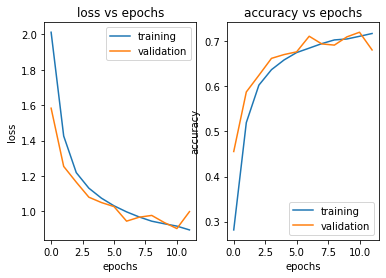

In [24]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["training","validation"])
plt.subplot(1,2,2)
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("accuracy vs epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["training","validation"])

In [25]:
testLoss, testAcc = model.evaluate(xTestGray, yTest, verbose=0)
print(f"loss: {testLoss}\n accuracy: {testAcc}%")

loss: 1.113389492034912
 accuracy: 0.6563460230827332%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [26]:
#l1Rate = 0.05
#l2Rate = 0.005 ,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1Rate,l2=l2Rate) 
dropoutRate = 0.2
model2 = Sequential()
model2.add(Conv2D(32,kernel_size=3,padding="SAME",activation="relu",input_shape=(32,32,1)))
model2.add(MaxPool2D(pool_size = 2))
model2.add(Conv2D(64,kernel_size=3,padding="SAME",activation="relu"))
model2.add(MaxPool2D(pool_size = 2))
model2.add(Flatten())
model2.add(Dense(128,activation="relu"))
model2.add(Dropout(dropoutRate))
model2.add(Dense(32,activation="relu"))
model2.add(Dense(10,activation="softmax"))




In [27]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [28]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
newPath = "convCheckpoint/checkpoint"
newCheck = ModelCheckpoint(filepath=newPath, frequency='epoch', save_weights_only=True)
newStop = EarlyStopping(mode="min",patience = 5,min_delta = 0.05)

In [30]:
hist2 = model2.fit(xTrainGray,yTrainGray,epochs=30,validation_data=(xValGray,yValGray),callbacks=[newCheck,newStop])

Epoch 1/30
1832/1832 [==============================] - 12s 6ms/step - loss: 1.0723 - accuracy: 0.6475 - val_loss: 0.5704 - val_accuracy: 0.8339
Epoch 2/30
1832/1832 [==============================] - 9s 5ms/step - loss: 0.5619 - accuracy: 0.8289 - val_loss: 0.4919 - val_accuracy: 0.8548
Epoch 3/30
1832/1832 [==============================] - 9s 5ms/step - loss: 0.4788 - accuracy: 0.8535 - val_loss: 0.4380 - val_accuracy: 0.8685
Epoch 4/30
1832/1832 [==============================] - 10s 5ms/step - loss: 0.4307 - accuracy: 0.8676 - val_loss: 0.3999 - val_accuracy: 0.8814
Epoch 5/30
1832/1832 [==============================] - 9s 5ms/step - loss: 0.4001 - accuracy: 0.8769 - val_loss: 0.3969 - val_accuracy: 0.8823
Epoch 6/30
1832/1832 [==============================] - 9s 5ms/step - loss: 0.3724 - accuracy: 0.8857 - val_loss: 0.4158 - val_accuracy: 0.8793
Epoch 7/30
1832/1832 [==============================] - 9s 5ms/step - loss: 0.3535 - accuracy: 0.8911 - val_loss: 0.3894 - val_accurac

In [31]:
print(hist2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


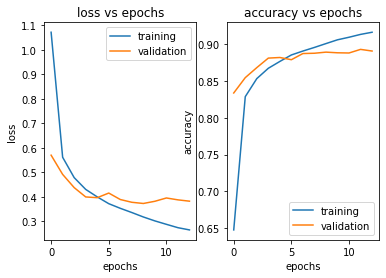

In [32]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(hist2.history["loss"])
plt.plot(hist2.history["val_loss"])
plt.title("loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["training","validation"])
plt.subplot(1,2,2)
plt.plot(hist2.history["accuracy"])
plt.plot(hist2.history["val_accuracy"])
plt.title("accuracy vs epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["training","validation"])

In [33]:
testLoss2, testAcc2 = model2.evaluate(xTestGray, yTest, verbose=0)
print(f"loss: {testLoss2}\n accuracy: {testAcc2}%")

loss: 0.40843114256858826
 accuracy: 0.8887138962745667%


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [34]:
def getNeuralModel():
    model = Sequential()
    model.add(Flatten(input_shape=(32,32,1)))
    model.add(Dense(512,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(64,activation="relu"))
    model.add(Dense(10,activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
    return model
    
def getConvModel():
    dropoutRate = 0.2
    model2 = Sequential()
    model2.add(Conv2D(32,kernel_size=3,padding="SAME",activation="relu",input_shape=(32,32,1)))
    model2.add(MaxPool2D(pool_size = 2))
    model2.add(Conv2D(64,kernel_size=3,padding="SAME",activation="relu"))
    model2.add(MaxPool2D(pool_size = 2))
    model2.add(Flatten())
    model2.add(Dense(128,activation="relu"))
    model2.add(Dropout(dropoutRate))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(10,activation="softmax"))  
    model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model2

In [35]:
def accuracyModel(model,xTest = xTestGray,yTest=yTest):
    loss,acc = model.evaluate(xTest,yTest,verbose = 0)
    print(f"accuracy:{acc} | loss: {loss}")

In [36]:
neuralFile =  tf.train.latest_checkpoint("modelCheckpoints")
convFile = tf.train.latest_checkpoint("convCheckpoint")

In [37]:
neuralModel = getNeuralModel()
neuralModel.load_weights(neuralFile)
accuracyModel(neuralModel)

accuracy:0.6563460230827332 | loss: 1.113389492034912


In [38]:
convModel = getConvModel()
convModel.load_weights(convFile)
accuracyModel(convModel)

accuracy:0.8887138962745667 | loss: 0.40843114256858826


In [39]:
neuralPredictions = neuralModel.predict(xTestGray)

In [40]:
convPredictions = convModel.predict(xTestGray)

In [41]:
def plotImageNice(label,image,prediction):
    pred = list(range(10))[np.argmax(prediction)]
    lab = list(range(10))[np.argmax(label)]
    plt.figure()
    plt.subplot(1,2,1)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Prediction: {pred} | real: {lab}")
    plt.imshow(image,cmap="gray")
    plt.subplot(1,2,2)
    plt.title("softmax probability Distribution")
    plt.bar(range(10),prediction)

In [42]:
testLen = yTest.shape[0]
indices = np.random.choice(testLen,5)

In [43]:
convPredictions = convPredictions[indices]
labels = yTest[indices]
images = xTestGray[indices,:,:,0]

# Convolutional Neural Network Predictions

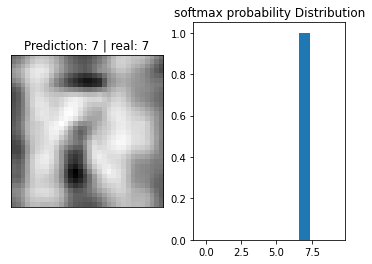

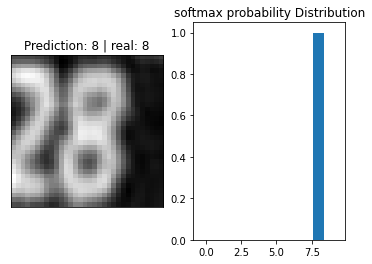

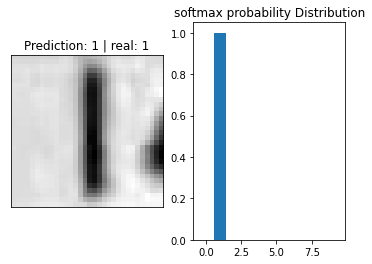

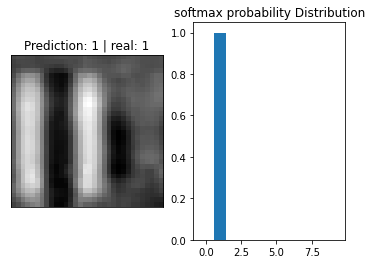

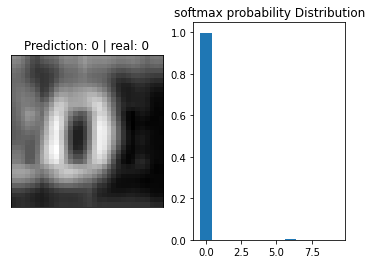

In [44]:
plotImageNice(labels[0],images[0],convPredictions[0])
plotImageNice(labels[1],images[1],convPredictions[1])
plotImageNice(labels[2],images[2],convPredictions[2])
plotImageNice(labels[3],images[3],convPredictions[3])
plotImageNice(labels[4],images[4],convPredictions[4])



# Normal Neural Network Predictions

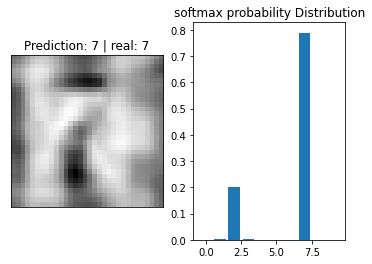

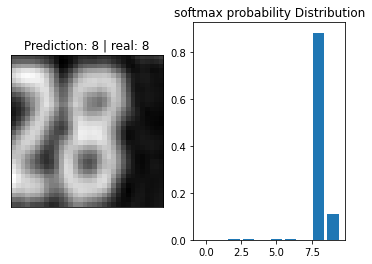

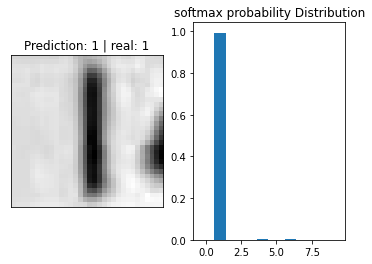

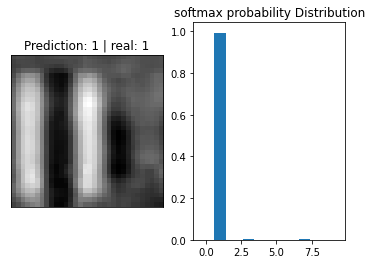

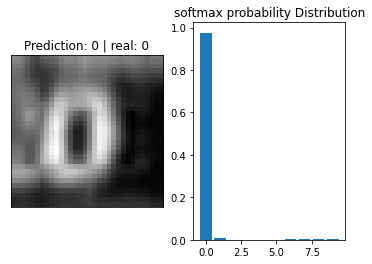

In [45]:
neuralPredictions = neuralPredictions[indices]
plotImageNice(labels[0],images[0],neuralPredictions[0])
plotImageNice(labels[1],images[1],neuralPredictions[1])
plotImageNice(labels[2],images[2],neuralPredictions[2])
plotImageNice(labels[3],images[3],neuralPredictions[3])
plotImageNice(labels[4],images[4],neuralPredictions[4])